In [1]:
import pandas as pd
import seaborn as sns
import sklearn

print("Pandas version:", pd.__version__)
print("Seaborn version:", sns.__version__)
print("Sklearn version:", sklearn.__version__)

Pandas version: 2.2.2
Seaborn version: 0.13.2
Sklearn version: 1.5.1


In [2]:
#carregando dados
dados_cancer = pd.read_csv('./dataset/breast_cancer.csv', sep=',')

In [3]:
dados_cancer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175 entries, 0 to 174
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             175 non-null    int64  
 1   BMI             175 non-null    float64
 2   Glucose         175 non-null    int64  
 3   Insulin         175 non-null    float64
 4   HOMA            175 non-null    float64
 5   Leptin          175 non-null    float64
 6   Adiponectin     175 non-null    float64
 7   Resistin        175 non-null    float64
 8   MCP.1           175 non-null    float64
 9   Classification  175 non-null    int64  
dtypes: float64(7), int64(3)
memory usage: 13.8 KB


In [4]:
#verificar valores nulos
dados_cancer.isna().sum()

Age               0
BMI               0
Glucose           0
Insulin           0
HOMA              0
Leptin            0
Adiponectin       0
Resistin          0
MCP.1             0
Classification    0
dtype: int64

n teve dado nulo

In [6]:
#contar numero de registros de classes para ver se esta balanceado
dados_cancer.groupby(['Classification'])['Classification'].count()

Classification
1     52
2    123
Name: Classification, dtype: int64

In [7]:
# Verificar se há dados duplicados
dados_cancer_duplicados = dados_cancer.duplicated().sum()
print(f"Número de registros duplicados: {dados_cancer_duplicados}")

Número de registros duplicados: 59


In [8]:
# Eliminar os dados duplicados
dados_cancer_sem_duplicados = dados_cancer.drop_duplicates()

# Verificar novamente se há duplicados após a remoção
duplicados_restantes = dados_cancer_sem_duplicados.duplicated().sum()
print(f"Número de registros duplicados após a remoção: {duplicados_restantes}")

Número de registros duplicados após a remoção: 0


In [9]:
#contar numero de registros de classes para ver se esta balanceado
dados_cancer.groupby(['Classification'])['Classification'].count()

Classification
1     52
2    123
Name: Classification, dtype: int64

In [10]:
#contar numero de registros de classes para ver se esta balanceado
dados_cancer_sem_duplicados.groupby(['Classification'])['Classification'].count()

Classification
1    52
2    64
Name: Classification, dtype: int64

In [13]:
!pip install imbalanced-learn

from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

  Using cached imbalanced_learn-0.12.4-py3-none-any.whl.metadata (8.3 kB)
Using cached imbalanced_learn-0.12.4-py3-none-any.whl (258 kB)


In [14]:
#separando conjunto de dados de features e target
x_dados = dados_cancer_sem_duplicados.drop('Classification', axis=1).values
y_dados = dados_cancer_sem_duplicados['Classification'].values

In [15]:
#criando função para balancear os dados
def balanceamento_dados(x_dados, y_dados):
    undersample = RandomUnderSampler(random_state=42)
    x_under, y_under = undersample.fit_resample(x_dados, y_dados)

    tl = TomekLinks(sampling_strategy='all')
    x_under, y_under = tl.fit_resample(x_under, y_under)
    return x_under, y_under

In [16]:
#aplicando tecnica de balanceamento de dados
x_dados_balanceados, y_dados_balanceados = balanceamento_dados(x_dados, y_dados)
print(len(x_dados_balanceados), len(y_dados_balanceados))

90 90


In [17]:
#verificar lista com dados balanceados
import collections
print(collections.Counter(y_dados_balanceados))

Counter({np.int64(1): 45, np.int64(2): 45})


In [19]:
#criando uma funcao para separar conjunto de treino e teste

def separa_treino_teste(x_dados_balanceados, y_dados_balanceados):
    x_train, x_test, y_train, y_test = train_test_split(x_dados_balanceados, y_dados_balanceados, random_state=42, test_size=0.3)
    return x_train, x_test, y_train, y_test

In [20]:
#separando conjuntos de treino e teste
x_train, x_test, y_train, y_test = separa_treino_teste(x_dados_balanceados, y_dados_balanceados)

In [26]:
#criando random forest
from sklearn.ensemble import RandomForestClassifier

#criar o classificador do RF
classifier = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=100)

#cria modelo de classificação
modelo = classifier.fit(x_train, y_train)

#realiza predicoes
y_pred = modelo.predict(x_test)


In [27]:
#verificando a importancia de cada feature no modelo (cada "variavel")
print(modelo.feature_importances_)

[0.11180512 0.10124459 0.17246203 0.08254185 0.08947523 0.06203717
 0.05301861 0.27350805 0.05390737]


In [28]:
dados_cancer_sem_duplicados.columns

Index(['Age', 'BMI', 'Glucose', 'Insulin', 'HOMA', 'Leptin', 'Adiponectin',
       'Resistin', 'MCP.1', 'Classification'],
      dtype='object')

In [29]:
#colocando em formato de dataframe (especie de coeficientes das variaveis)
pd.DataFrame(modelo.feature_importances_, columns=['importancia'],
             index = ['Age', 'BMI', 'Glucose', 'Insulin', 'HOMA', 'Leptin', 'Adiponectin',
       'Resistin', 'MCP.1']).sort_values('importancia', ascending=False)

,importancia
Resistin,0.273508
Glucose,0.172462
Age,0.111805
BMI,0.101245
HOMA,0.089475
Insulin,0.082542
Leptin,0.062037
MCP.1,0.053907
Adiponectin,0.053019


In [30]:
#calculando acuracia do modelo
acuracia = accuracy_score(y_test, y_pred)
acuracia

0.7777777777777778

In [31]:
# Calcular correlação das variáveis com a variável Classification
correlation_matrix = dados_cancer_sem_duplicados.corr()
classification_correlation = correlation_matrix['Classification'].drop('Classification')

# Identificar a variável com a maior correlação absoluta
highest_correlation_var = classification_correlation.abs().idxmax()
highest_correlation_value = classification_correlation[highest_correlation_var]

print(f"Variável com maior correlação com Classification: {highest_correlation_var} ({highest_correlation_value:.3f})")

Variável com maior correlação com Classification: Glucose (0.384)


In [34]:
# Calcular correlação das variáveis com a variável Classification (BASE SEM EXCLUIR DUPLICAÇÃO)
correlation_matrix = dados_cancer.corr()
classification_correlation = correlation_matrix['Classification'].drop('Classification')

# Identificar a variável com a maior correlação absoluta
highest_correlation_var = classification_correlation.abs().idxmax()
highest_correlation_value = classification_correlation[highest_correlation_var]

print(f"Variável com maior correlação com Classification: {highest_correlation_var} ({highest_correlation_value:.3f})")

Variável com maior correlação com Classification: Glucose (0.335)


In [32]:
# Calcular a média de idade das pessoas classificadas como saudáveis
media_idade_saudaveis = dados_cancer_sem_duplicados[dados_cancer_sem_duplicados['Classification'] == 1]['Age'].mean()

print(f"Média de idade das pessoas classificadas como saudáveis: {media_idade_saudaveis:.2f}")

Média de idade das pessoas classificadas como saudáveis: 58.08


In [38]:
# Calcular a média de idade das pessoas classificadas como saudáveis (BASE SEM EXCLUIR DUPLICAÇÃO)
media_idade_saudaveis = dados_cancer[dados_cancer['Classification'] == 1]['Age'].mean()

print(f"Média de idade das pessoas classificadas como saudáveis: {media_idade_saudaveis:.2f}")

Média de idade das pessoas classificadas como saudáveis: 58.08


In [39]:
# Calcular a média de GLICOSE das pessoas diagnosticada com Cancer
media_idade_saudaveis = dados_cancer_sem_duplicados[dados_cancer_sem_duplicados['Classification'] == 2]['Glucose'].mean()

print(f"Média de idade das pessoas classificadas como saudáveis: {media_idade_saudaveis:.2f}")

Média de idade das pessoas classificadas como saudáveis: 105.56


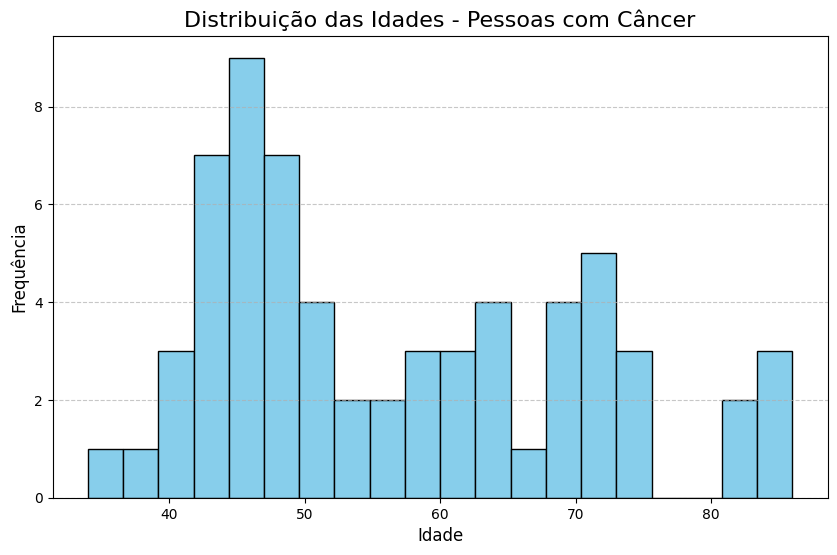

In [41]:
import matplotlib.pyplot as plt

# Filtrar as idades das pessoas diagnosticadas com câncer
idades_cancer = dados_cancer_sem_duplicados[dados_cancer_sem_duplicados['Classification'] == 2]['Age']

# Construir o histograma
plt.figure(figsize=(10, 6))
plt.hist(idades_cancer, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribuição das Idades - Pessoas com Câncer', fontsize=16)
plt.xlabel('Idade', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


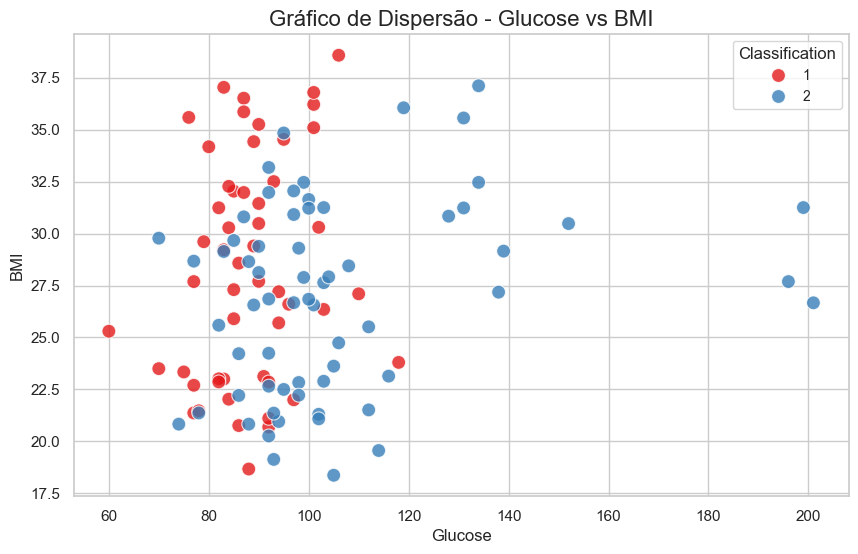

In [42]:
import seaborn as sns

# Configurar o estilo do Seaborn
sns.set(style="whitegrid")

# Criar o gráfico de dispersão
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=dados_cancer_sem_duplicados,
    x='Glucose',
    y='BMI',
    hue='Classification',
    palette='Set1',  # Define cores diferentes para os grupos
    alpha=0.8,       # Define a transparência dos pontos
    s=100            # Tamanho dos pontos
)

# Configurar título e rótulos
plt.title('Gráfico de Dispersão - Glucose vs BMI', fontsize=16)
plt.xlabel('Glucose', fontsize=12)
plt.ylabel('BMI', fontsize=12)
plt.legend(title='Classification', loc='upper right', fontsize=10)
plt.show()


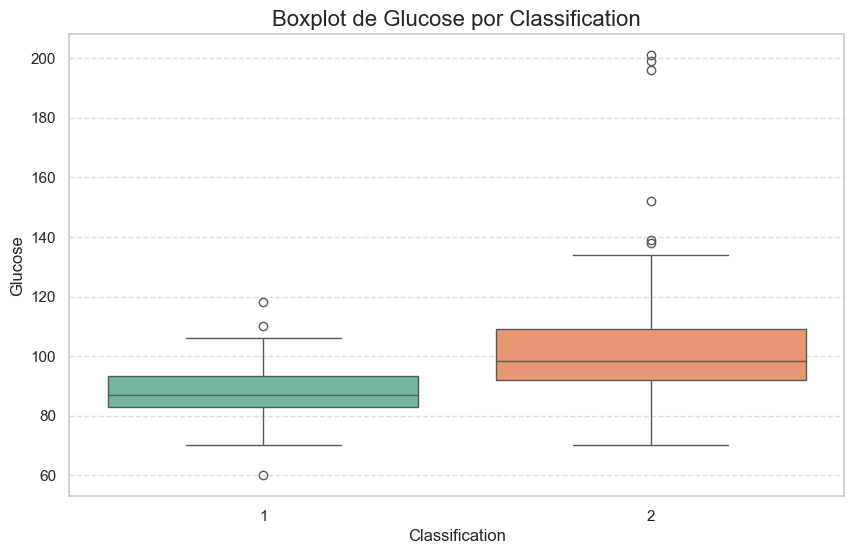

In [44]:
# Configurar o estilo do Seaborn
sns.set(style="whitegrid")

# Criar o boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=dados_cancer_sem_duplicados,
    x='Classification',
    y='Glucose',
    hue='Classification',  # Ajustar 'hue' para corresponder ao agrupamento
    dodge=False,           # Evitar deslocamento, mantém o gráfico claro
    palette='Set2'
)

# Configurar título e rótulos
plt.title('Boxplot de Glucose por Classification', fontsize=16)
plt.xlabel('Classification', fontsize=12)
plt.ylabel('Glucose', fontsize=12)
plt.legend([], [], frameon=False)  # Remove legenda desnecessária
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [46]:
#criando a matrix de confusao
from sklearn.metrics import confusion_matrix, classification_report

In [47]:
#criando a matrix de confusao
cm = confusion_matrix(y_test, y_pred)

<function matplotlib.pyplot.show(close=None, block=None)>

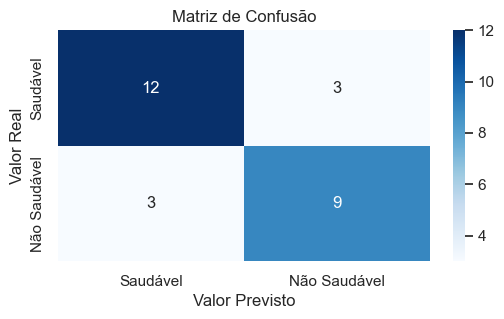

In [48]:
#visualizar a matriz de confusao
#definindo os rotulos
labels = ['Saudável', 'Não Saudável']

plt.figure(figsize=(6,3))
sns.heatmap(data=cm,
            annot=True,
            cmap='Blues',
            xticklabels=labels,
            yticklabels=labels
           )

plt.xlabel('Valor Previsto')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusão')
plt.show

In [49]:
#gerar o relatorio de classificação
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           1       0.80      0.80      0.80        15
           2       0.75      0.75      0.75        12

    accuracy                           0.78        27
   macro avg       0.78      0.78      0.78        27
weighted avg       0.78      0.78      0.78        27

